In [1]:
import autograd.numpy as np  
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, sep=';')

print("Quality distribution in dataset:")
print(data['quality'].value_counts().sort_index())

X = data.drop('quality', axis=1).values
y_raw = data['quality'].values

#Important
# Choose task: comment/uncomment one of the two lines below

# BINARY CLASSIFICATION (Good >6 vs Bad ≤6)
#y_task = (y_raw > 6).astype(int)                  # Use this for binary

# MULTICLASS CLASSIFICATION (7 classes, labels 0-6)
y_task = y_raw - 3                               # Use this for multiclass

if y_task[0] == 0:   #The first quality is a six, thus y_task[0] is 0 if binary
    Fill = 2
else:
    Fill = 7

# Train/test split
X_train_raw, X_test_raw, y_train_task, y_test_task = train_test_split(
    X, y_task, test_size=200/4898, random_state=42, stratify=y_task
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# One-hot encode targets
enc = OneHotEncoder(sparse_output=False)
y_train = enc.fit_transform(y_train_task.reshape(-1, 1))
y_test = enc.transform(y_test_task.reshape(-1, 1))

if y_train.shape[1] == 2:
    print("Binary classification ready:")
    print(f" Good wines in test set: {y_test_task.sum()} / {len(y_test_task)}")
else:
    print("Multiclass classification ready (7 classes)")

print(f" X_train: {X_train.shape}, y_train (one-hot): {y_train.shape}")
print(f" X_test:  {X_test.shape},  y_test (one-hot):  {y_test.shape}")

# Table showing data
df = pd.read_csv(url, sep=';')
df.head()

Quality distribution in dataset:
quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64
Multiclass classification ready (7 classes)
 X_train: (4698, 11), y_train (one-hot): (4698, 7)
 X_test:  (200, 11),  y_test (one-hot):  (200, 7)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


(4698,)
(200,)
(4698, 11)
(200, 11)
XGBoost Classification Accuracy: 0.7000


 99%|===================| 1389/1400 [01:51<00:00]        

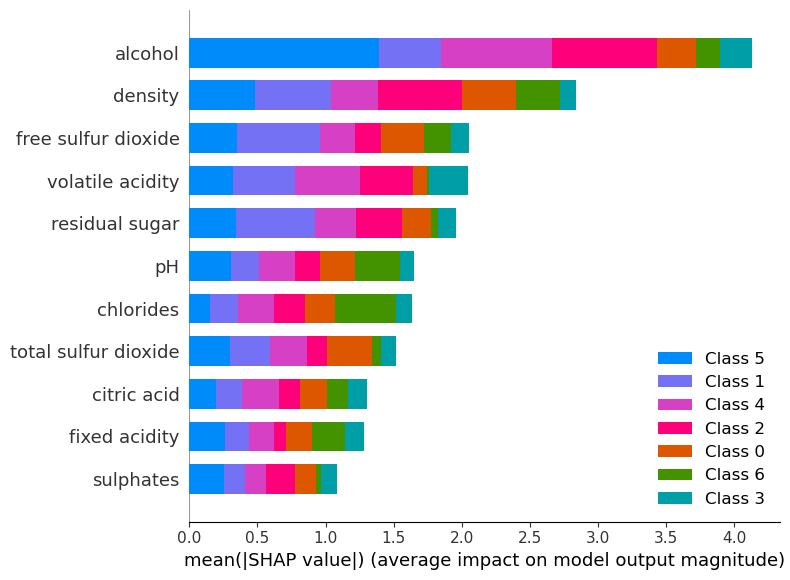

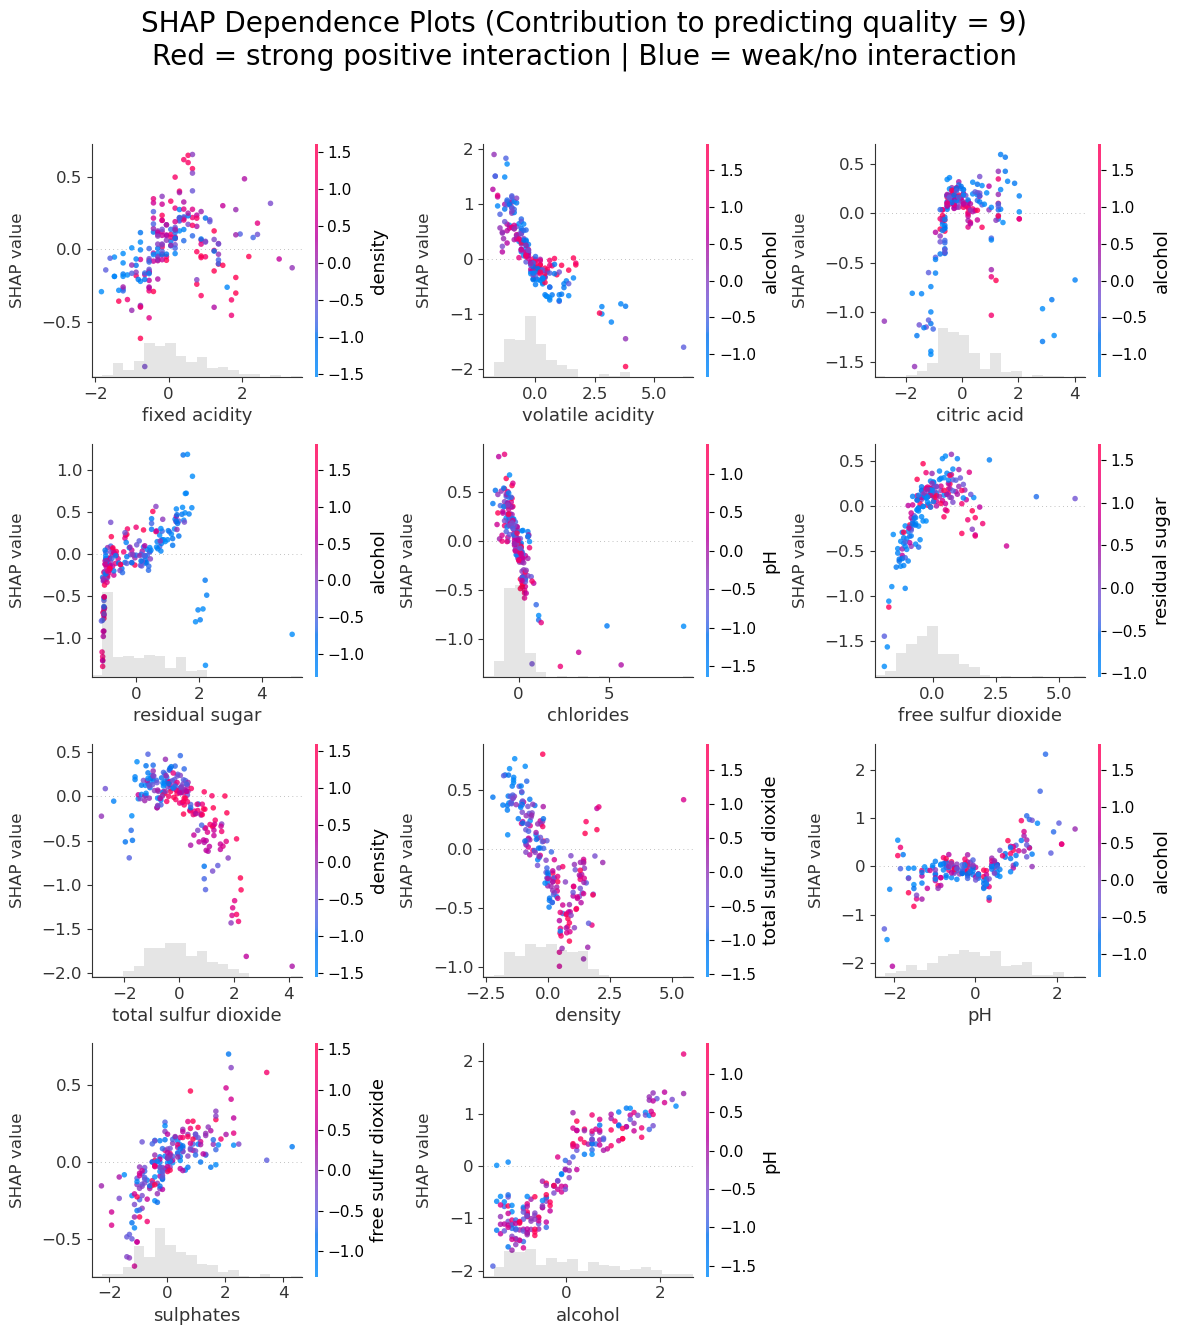

In [3]:

# XGBoost

import matplotlib.pyplot as plt

y_train = y_train_task.copy() # Tree models work best with unprosessed data
y_test  = y_test_task.copy()

print(y_train.shape) #Check shapes
print(y_test.shape)
print(X_train.shape)  
print(X_test.shape) 

# XGBoost with Shap feature analysis
# Info on shap +XGBoost and how I used it, visit:
# https://shap.readthedocs.io/en/latest/index.html
# https://xgboost.readthedocs.io/en/stable/get_started.html

import shap
import xgboost as xgb

# Train a quick XGBoost model (SHAP works best with tree models)
model = xgb.XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)   # or use your multiclass/regression version
pred = model.predict(X_test)
print(f"XGBoost Classification Accuracy: {accuracy_score(y_test, pred):.4f}")

explainer = shap.Explainer(model, X_train)      # model = trained XGBClassifier
shap_values = explainer(X_test)

shap_values.feature_names = data.columns[:-1].tolist()               # 11 chemical features
shap_values.output_names = [f"quality = {q}" for q in range(3, 10)]  # ['quality = 3', 'quality = 4', ..., 'quality = 9']
                                                               
shap.summary_plot(shap_values, max_display=11)  #First plot is for all classes in one figure

####

#Second plot is for how each test sample fits in a certain quality:

import shap
import matplotlib.pyplot as plt
import numpy as np

if Fill > 2:

    class_idx = 4  # Choose quality to analyse: 0=quality3, 1=quality4, ..., 6=quality9

    # Extract SHAP values for that class only: now shape (n_samples, 11)

    shap_class = shap_values[:, :, class_idx] 

    shap_class.feature_names = shap_values.feature_names

    # Select the first 11 features 
    features_to_plot = shap_class.feature_names[:11]  

    n_features = len(features_to_plot)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols  # ceiling division: 4 rows for 11 features

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 14)) 
    axes = axes.flatten()  

    for i, feature in enumerate(features_to_plot):
        shap.plots.scatter(
            shap_class[:, feature],
            color=shap_class,           
            ax=axes[i],
            show=False,
            alpha=0.8,
        )
        # Remove individual subplot title, (Alreaddy at the x-axis)
        axes[i].set_title("")      
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        axes[i].set_ylabel("SHAP value", fontsize=12, labelpad=12)
    
    # Hide unused subplots (the last one in a 4×3 grid will be empty)
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(
        "SHAP Dependence Plots (Contribution to predicting quality = 9)\n"
        "Red = strong positive interaction | Blue = weak/no interaction",
        fontsize=20,
        y=0.98
    )
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

y_train = enc.fit_transform(y_train_task.reshape(-1, 1))  #Setting the data back to 
y_test  = enc.transform(y_test_task.reshape(-1, 1))         


In [4]:
# Neural network
#Defining some activation functions and their derivative
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

def mse(predict, target):
    return np.mean((predict - target) ** 2)

def mse_der(predict, target):
    return 2 * (predict - target) / np.prod(predict.shape)

def softmax(z):
    """Compute softmax values for each set of scores in the rows of the matrix z.
    Used with batched input data."""
    e_z = np.exp(z - np.max(z, axis=1)[:, np.newaxis]) #substract max per row, avoids instability
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]

def softmax_vec(z):
    """Compute softmax values for each set of scores in the vector z.
    Use this function when you use the activation function on one vector at a time"""
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z)

def softmax_der(z):
    return np.ones_like(z) 
#Purely placeholder, combined derivative 
#Cross entropy + softmax simplifies to predict-target

def cross_entropy(predict, target):
    return np.mean(-np.sum(target * np.log(predict + 1e-10), axis=1))

def cross_entropy_der(predict, target):
    return (predict - target) / predict.shape[0]


In [5]:
#Initializing creation of n layers for batched input shapes

def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []
    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        std = np.sqrt(2 / i_size) 
        W = np.random.randn(i_size, layer_output_size) * std  #Making sure the shapes macth
        b = np.zeros(layer_output_size)
        layers.append((W, b))
        i_size = layer_output_size
    return layers

#Applying weights, bias and activation function and passing forward
def feed_forward_saver_batch(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

#Same, but when saving layer_inputs and zs is not needed
def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a @ W + b
        a = activation_func(z)
    return a

#Verify gradients
def cost(input, layers, activation_funcs, target):
    predict = feed_forward_saver_batch(input, layers, activation_funcs)[2]
    return mse(predict, target)

#Computing gradients
def backpropagation_batch(
    input, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver_batch(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = dC_dz @ W.T

        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz  #W gradients for batches
        dC_db = np.sum(dC_dz, axis=0)   #sum bias gradients, batch dim

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

In [6]:


def create_optimizer(optimizer_name="adam", lr=0.001):
    if optimizer_name == "sgd":
        return {"name": "sgd", "lr": lr}
    
    elif optimizer_name == "adam":
        return {
            "name": "adam",
            "lr": lr,
            "beta1": 0.9,
            "beta2": 0.999,
            "epsilon": 1e-8,
            "t": 0,
            "m": [],   #(m_W, m_b) for each layer
            "v": []    #(v_W, v_b) for each layer
        }
    
    elif optimizer_name == "rmsprop":
        return {
            "name": "rmsprop",
            "lr": lr,
            "beta": 0.99,
            "epsilon": 1e-8,
            "v": []
        }

def update_parameters(layers, grads, optimizer_config, t=None):
    
    #One function to rule them all.
    #Pass in your layers, gradients, and optimizer config → returns updated layers
    
    name = optimizer_config["name"]
    
    if name == "sgd":
        lr = optimizer_config["lr"]
        updated_layers = []
        for (W, b), (dW, db) in zip(layers, grads):
            W = W - lr * dW
            b = b - lr * db
            updated_layers.append((W, b))
        return updated_layers

    elif name == "adam":
        # Initialize m and v on first call
        if len(optimizer_config["m"]) == 0:
            optimizer_config["m"] = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
            optimizer_config["v"] = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
        
        beta1 = optimizer_config["beta1"]
        beta2 = optimizer_config["beta2"]
        lr = optimizer_config["lr"]
        eps = optimizer_config["epsilon"]
        t = optimizer_config["t"] + 1
        optimizer_config["t"] = t  # update timestep

        updated_layers = []
        for i, ((W, b), (dW, db)) in enumerate(zip(layers, grads)):
            m_W, m_b = optimizer_config["m"][i]
            v_W, v_b = optimizer_config["v"][i]

            #Adam update 
            m_W = beta1 * m_W + (1 - beta1) * dW
            m_b = beta1 * m_b + (1 - beta1) * db
            v_W = beta2 * v_W + (1 - beta2) * (dW ** 2)
            v_b = beta2 * v_b + (1 - beta2) * (db ** 2)

            m_hat_W = m_W / (1 - beta1 ** t)
            m_hat_b = m_b / (1 - beta1 ** t)
            v_hat_W = v_W / (1 - beta2 ** t)
            v_hat_b = v_b / (1 - beta2 ** t)

            W = W - lr * m_hat_W / (np.sqrt(v_hat_W) + eps)
            b = b - lr * m_hat_b / (np.sqrt(v_hat_b) + eps)

            #Save
            optimizer_config["m"][i] = (m_W, m_b)
            optimizer_config["v"][i] = (v_W, v_b)
            updated_layers.append((W, b))

        return updated_layers

  


In [7]:
def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)
    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

Epoch 1, Loss: 1.128, Test Accuracy: 0.515, Train Accuracy: 0.544
Epoch 2, Loss: 0.996, Test Accuracy: 0.515, Train Accuracy: 0.587
Epoch 3, Loss: 0.964, Test Accuracy: 0.545, Train Accuracy: 0.599
Epoch 4, Loss: 0.920, Test Accuracy: 0.550, Train Accuracy: 0.624
Epoch 5, Loss: 0.902, Test Accuracy: 0.560, Train Accuracy: 0.626
Epoch 6, Loss: 0.857, Test Accuracy: 0.545, Train Accuracy: 0.636
Epoch 7, Loss: 0.827, Test Accuracy: 0.555, Train Accuracy: 0.662
Epoch 8, Loss: 0.801, Test Accuracy: 0.555, Train Accuracy: 0.665
Epoch 9, Loss: 0.781, Test Accuracy: 0.550, Train Accuracy: 0.670
Epoch 10, Loss: 0.737, Test Accuracy: 0.555, Train Accuracy: 0.693
Epoch 11, Loss: 0.729, Test Accuracy: 0.590, Train Accuracy: 0.699
Epoch 12, Loss: 0.689, Test Accuracy: 0.580, Train Accuracy: 0.733
Epoch 13, Loss: 0.669, Test Accuracy: 0.540, Train Accuracy: 0.736
Epoch 14, Loss: 0.654, Test Accuracy: 0.555, Train Accuracy: 0.737
Epoch 15, Loss: 0.648, Test Accuracy: 0.575, Train Accuracy: 0.714
Epoc

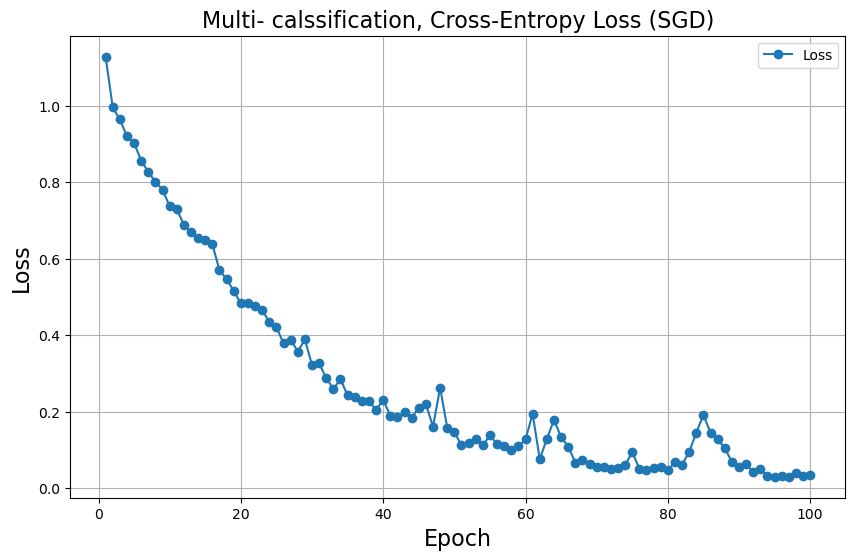

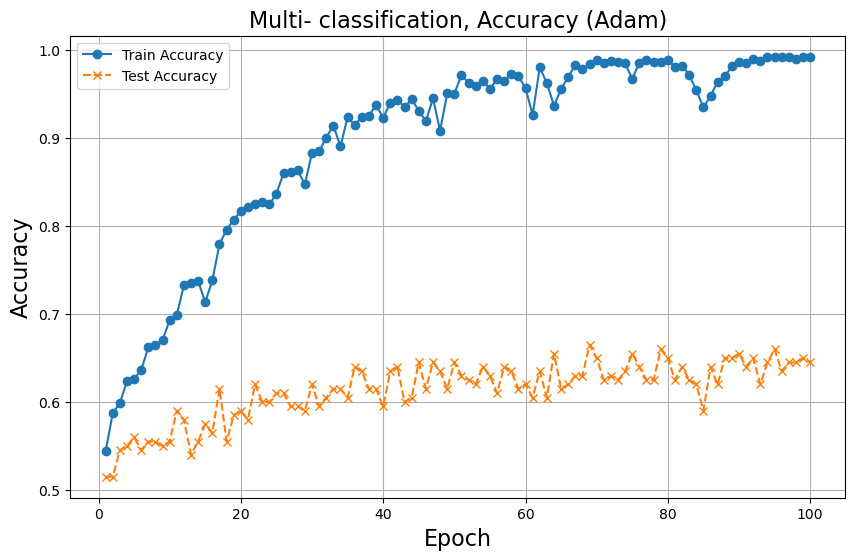

In [8]:

def train_network(X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size=100):
    losses = []
    train_accs = []  
    test_accs = []   
    optimizer = create_optimizer("adam", lr=0.001)   #choosing optimizer. adam or sgd (then lr=0.05)

    for epoch in range(epochs):
        # Shuffle digits, avoids learning misleading patterns. Independent data
        perm = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[perm] 
        y_shuffled = y_train[perm]
        
        # Mini-batch loop
        for start in range(0, X_train.shape[0], batch_size):
            end = start + batch_size
            input_batch = X_shuffled[start:end]
            target_batch = y_shuffled[start:end]
            
            layers_grad = backpropagation_batch(input_batch, layers, activation_funcs, target_batch, activation_ders, cost_der=cross_entropy_der)
            layers = update_parameters(layers, layers_grad, optimizer)   #use optimizer
            for (W, b), (W_g, b_g) in zip(layers, layers_grad):
                W -= learning_rate * W_g
                b -= learning_rate * b_g
        
        #Compute loss after epoch
        train_predictions = feed_forward(X_train, layers, activation_funcs)
        test_predictions = feed_forward(X_test, layers, activation_funcs)
        loss = cross_entropy(train_predictions, y_train)
        TESTacc = accuracy(test_predictions, y_test)
        TRAINacc = accuracy(train_predictions, y_train)
        losses.append(loss)
        train_accs.append(TRAINacc)  
        test_accs.append(TESTacc)    
        print(f"Epoch {epoch+1}, Loss: {loss:.3f}, Test Accuracy: {TESTacc:.3f}, Train Accuracy: {TRAINacc:.3f}") 
    
    return layers, losses, train_predictions, train_accs, test_accs  # Updated return

# Setup network skeleton 
network_input_size = 11
layer_output_sizes = [256, 128, 64, Fill]  # output 7 (if multiclass) OR 2 classes (if binary)
activation_funcs = [ReLU, ReLU, ReLU, softmax]
activation_ders = [ReLU_der, ReLU_der, ReLU_der, softmax_der] #Multiclass + 0.01 lr

#activation_funcs = [ReLU, ReLU, sigmoid, softmax]
#activation_ders = [ReLU_der, ReLU_der, sigmoid_der, softmax_der]

#activation_funcs = [sigmoid, sigmoid, sigmoid, softmax]  
#activation_ders = [sigmoid_der, sigmoid_der, sigmoid_der, softmax_der]

# Train
epochs = 100 
learning_rate = 0.1 #For testing without optimizer
batch_size = 100

# Create layers
layers = create_layers_batch(network_input_size, layer_output_sizes)

trained_layers, losses, train_predictions, train_accs, test_accs = train_network(
    X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size
)

# Plot loss as function of epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label='Loss', marker='o')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Multi- calssification, Cross-Entropy Loss (SGD)', fontsize = 16)
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracies (train and test) as function of epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy', marker='x', linestyle='--')
plt.xlabel('Epoch', fontsize = 16 )
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Multi- classification, Accuracy (Adam)', fontsize = 16)
plt.legend()
plt.grid(True)
plt.show()

